In [3]:
!pip install utm --user
!pip install pykalman --user
!pip install geopy --user
!pip install localreg --user
!pip install utm --user

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 92kB 700kB/s eta 0:00:011
  Created wheel for localreg: filename=localreg-0.4.0-cp36-none-any.whl size=30505 sha256=87b2b21183a97e3438146e29be7fbb6c03aa749337f31d30d6ba3bdba32fc420
  Stored in directory: /home/mist/.cache/pip/wheels/d4/e9/62/e748df1c1e1b08f36208720b107348725c34c4c5779157b50f
Successfully built localreg
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [4]:
# local polynomial regression + Deep Neural Decision Forests
import utm
import math
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from localreg import *
from mpl_toolkits.mplot3d import Axes3D
from pykalman import KalmanFilter
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
#from data_clean_all import data_clean_preprocess,clean_dataset
import random
from geopy.distance import geodesic
from tqdm import tqdm
import os
import glob
from tqdm import trange

'''
pip install utm --user
pip install pykalman --user
pip install geopy --user

pip install utm --user
'''

CLASS_NUM = 1000
TREE_DEPTH = 7
PLOT_ON = True
class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate=1.0, num_classes=1):
        super(NeuralDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )


    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.linear(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs


# In[ ]:


class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate=1.0, num_classes=1):
        super(NeuralDecisionForest, self).__init__()
        self.ensemble = []
        self.num_classes = num_classes
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, self.num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs


def create_tree_model(dim, regress=False):
    inputs = keras.Input(shape=(dim,))
    num_features = 32
    num_treeout = 32
    num_trees = 3
    y = layers.Dense(32, activation="relu")(inputs)
    y = layers.Dense(num_features, activation="relu")(y)
    # one can add norm: features = layers.BatchNormalization()(y)
    features = y
    tree = NeuralDecisionForest(num_trees, TREE_DEPTH, num_features, 1.0, num_treeout)
    y = tree(features)
    y = layers.Dense(16, activation="relu")(y)
    y = layers.Dense(8, activation="relu")(y)
    y = layers.Dense(4, activation="relu")(y)
    outputs = layers.Dense(1, activation="linear")(y)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# In[ ]:


def predict_se(model, X_test, y_test, dataset_SE_max, plot=PLOT_ON):
    print("[INFO] predicting...")
    preds = model.predict(X_test).flatten()
    y_test = y_test.flatten()
    diff = abs(preds-y_test)*dataset_SE_max
    # choose how many bins you want here
    num_bins = 30
    # use the histogram function to bin the data
    counts, bin_edges = np.histogram(diff, bins=num_bins)
    # now find the cdf
    cdf = np.cumsum(counts)
    # and finally plot the cdf
    if plot:
        plt.plot(bin_edges[1:], cdf)
        plt.xlabel('Absolute Error (Mbit/Number)')
        plt.ylabel('Count')
        plt.title('Error CDF')
        plt.show()
    diff_percen = abs(preds-y_test)/y_test
    mean = np.mean(abs(diff))
    std = np.std(diff)
    print("[INFO] error mean: {:.3f}, std: {:.3f}".format(mean, std))
    mean = np.mean(abs(diff_percen))
    std = np.std(diff_percen)
    print("[INFO] percentage error mean: {:.3f}, std: {:.3f}" .format(mean, std))
    axis_lim = y_test.mean()*dataset_SE_max*2
    # mean absolute percentage error by sections
    diff_with_y = np.hstack((y_test[:,np.newaxis]*dataset_SE_max, diff_percen[:,np.newaxis]))
    sort_indices = np.argsort(diff_with_y[:,0])
    diff_with_y = diff_with_y[sort_indices,:]
    mape_sections = np.array([1000, 1500, 2500, np.iinfo(int).max])
    mape_sections_mean = np.empty(len(mape_sections))
    idx_section = 0
    diff_id_section = 0
    for i in range(len(diff_with_y)):
        if diff_with_y[i,0]>mape_sections[idx_section] or i == len(diff_with_y)-1:
            mape_sections_mean[idx_section] = np.mean(diff_with_y[diff_id_section:i,1])
            diff_id_section = i
            idx_section = idx_section + 1
    print("[INFO] MAPE by sections: ", np.around(mape_sections_mean, decimals=2))
    if plot:
        plt.figure()
        plt.plot(preds.flatten()*dataset_SE_max, y_test*dataset_SE_max, '.')
        plt.plot([0, axis_lim], [0, axis_lim])
        plt.axis([0, axis_lim, 0, axis_lim])
        plt.xlabel('Prediction (Mbit/Number)')
        plt.ylabel('Ground Truth (Mbit/Number)')
        plt.title('Spectral Efficiency')
        plt.show()


# ## Main

# In[ ]:


def trainAndPredict(eps,plotOn,X_train,y_train,X_val,y_val,X_test,y_test,dataset_SE_max):

    # assign weights
    sample_weight = np.ones(shape=(len(y_train),))
    # sample_weight = compute_sample_weight('balanced', np.rint(y_train * CLASS_NUM))
    # sample_weight = sample_weight.clip(min=0, max=10)
    # # manually assign weights
    # # sample_weight[y_train <= 1000/dataset_SE_max] = 5
    # # sample_weight[(y_train > 1000/dataset_SE_max) & (y_train < 1500/dataset_SE_max)] = 7
    # # sample_weight[y_train >= 2500/dataset_SE_max] = 6.5
    # plt.hist(y_train*dataset_SE_max, range(480, 3200, 100))
    # plt.xlabel('Spectral Efficiency (Mbit/RB)')
    # plt.ylabel('Count')
    # plt.title('Spectral Efficiency PDF')

    # load the TensorBoard notebook extension.
    #%load_ext tensorboard
    logdir = "logs/scalars/" + time.strftime("%Y%m%d-%H%M%S", time.localtime())
    file_writer = tf.summary.create_file_writer(logdir + "/metrics")
    file_writer.set_as_default()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=logdir, update_freq='epoch', profile_batch=0)
    model = create_tree_model(X_train.shape[1], regress=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
        patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=10, min_lr=0)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        patience=15, verbose=1, mode='auto', restore_best_weights=True)
    opt = tf.keras.optimizers.Adam(lr=0.001) #learn rate
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    # train the model
    print("[INFO] pretraining model...")
    # model.fit(x=X_pretrain, y=y_pretrain, epochs=3, batch_size=64)
    print("[INFO] training model...")
    training_history = model.fit(x=X_train, y=y_train,
        validation_data=(X_val, y_val),
        epochs=eps, batch_size=64, sample_weight=sample_weight,
        callbacks=[reduce_lr, early_stop, tensorboard_callback])

    # make predictions on the testing data
    predict_se(model, X_train, y_train, dataset_SE_max, plotOn)
    predict_se(model, X_val, y_val, dataset_SE_max, plotOn)
    predict_se(model, X_test, y_test, dataset_SE_max, plotOn)
    if plotOn:
        dot_img_file = 'figures/model_1.png'
        tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    #%tensorboard --logdir logs/scalars


# [0:16] dataset_pcell_csi_rsrp
# [17:32]dataset_pcell_csi_rsrp_std
# [33,]dataset_ri
# [34,]dataset_mcs
# [35,]dataset_cqi
# [36,41]dataset_ncell_ss_rsrp
# [42,47]dataset_ncell_ss_rsrp_std




In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


[INFO] pretraining model...
[INFO] training model...


Epoch 1/10
21130/21130 [==============================] - 155s 7ms/step - loss: 9.5912 - val_loss: 8.3477
Epoch 2/10
21130/21130 [==============================] - 151s 7ms/step - loss: 7.3551 - val_loss: 7.8556
Epoch 3/10
21130/21130 [==============================] - 147s 7ms/step - loss: 7.2881 - val_loss: 8.1456
Epoch 4/10
21130/21130 [==============================] - 149s 7ms/step - loss: 7.2355 - val_loss: 7.5926
Epoch 5/10
21130/21130 [==============================] - 143s 7ms/step - loss: 7.2108 - val_loss: 7.7520
Epoch 6/10
21130/21130 [==============================] - 140s 7ms/step - loss: 7.1761 - val_loss: 7.7924
Epoch 7/10
21130/21130 [==============================] - 149s 7ms/step - loss: 7.1815 - val_loss: 7.6311
Epoch 8/10
21130/21130 [==============================] - 139s 7ms/step - loss: 7.1611 - val_loss: 8.1211
Epoch 9/10
21130/21130 [==============================] - 149s 7ms/step - loss: 7.1368 - val_loss: 7.9855
Epoch 10/10
21130/21130 [=====================

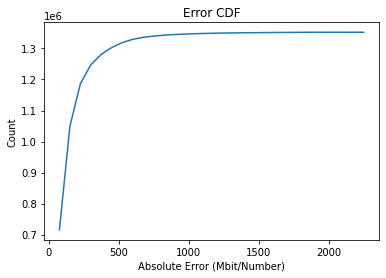

[INFO] error mean: 114.043, std: 149.115
[INFO] percentage error mean: 0.071, std: 0.107
[INFO] MAPE by sections:  [0.13 0.08 0.06 0.05]


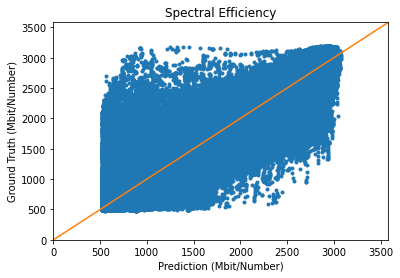

[INFO] predicting...


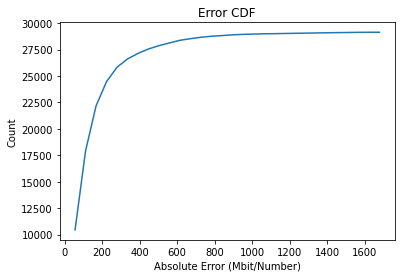

[INFO] error mean: 135.956, std: 171.048
[INFO] percentage error mean: 0.077, std: 0.102
[INFO] MAPE by sections:  [0.12 0.1  0.07 0.06]


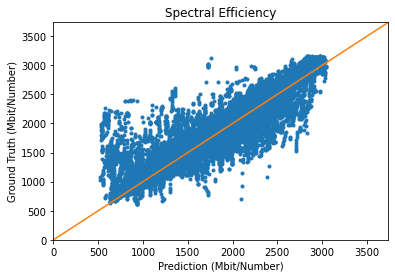

[INFO] predicting...


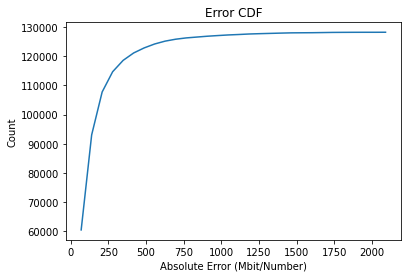

[INFO] error mean: 128.806, std: 176.035
[INFO] percentage error mean: 0.074, std: 0.103
[INFO] MAPE by sections:  [0.13 0.1  0.07 0.06]


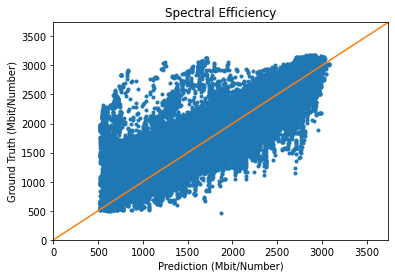

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [7]:
with open('DataSet_2021_8_5_filter_combine_normalize.pkl', 'rb') as f:
    X_train,y_train,X_val,y_val,X_test,y_test,y_max = pickle.load(f) #dataset_y用于分析将归一化预测还原,数据如果不归一化，就令dataset_SE_max=1
trainAndPredict(10,True,X_train[:,0:34],y_train[:,0],X_val[:,0:34],y_val[:,0],X_test[:,0:34],y_test[:,0],y_max[0,0])